In [1]:
from google.colab import files
uploaded = files.upload()


Saving assamdata.csv to assamdata (4).csv


Loaded shape: (4213, 99)
Target distribution (realism-focused):
target_outbreak
0    3790
1     423
Name: count, dtype: int64
Class distribution after SMOTE: [3032 3032]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       758
           1       0.79      0.88      0.83        85

    accuracy                           0.96       843
   macro avg       0.89      0.93      0.91       843
weighted avg       0.97      0.96      0.97       843

🔥 ROC-AUC: 0.9907496507837964


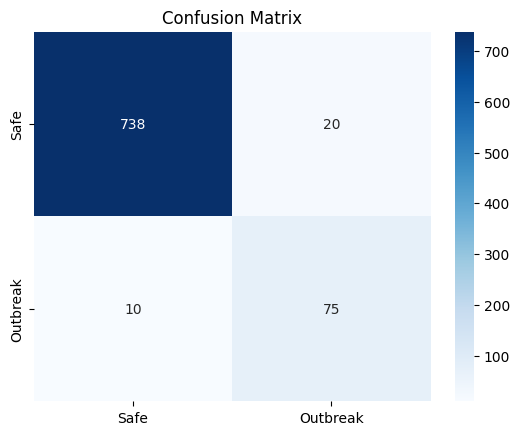

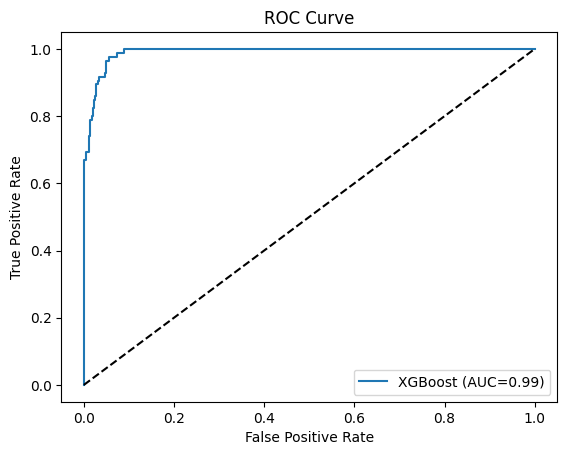


🚨 Alerts Raised: 500 out of 4213


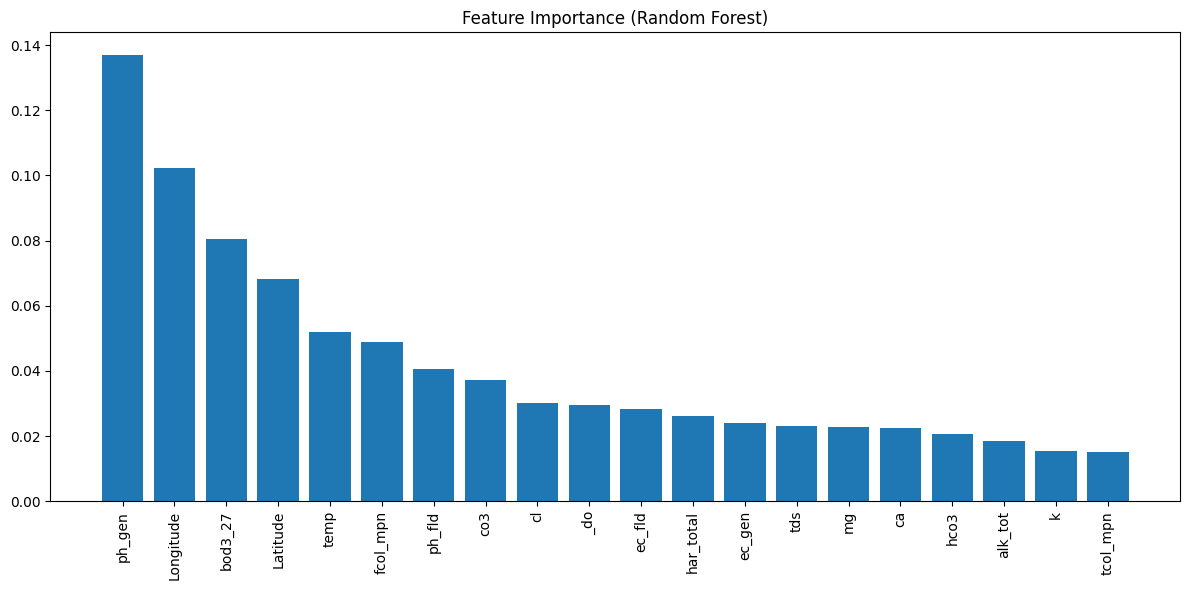

SHAP shape: (843, 88, 2) X_test shape: (843, 88)


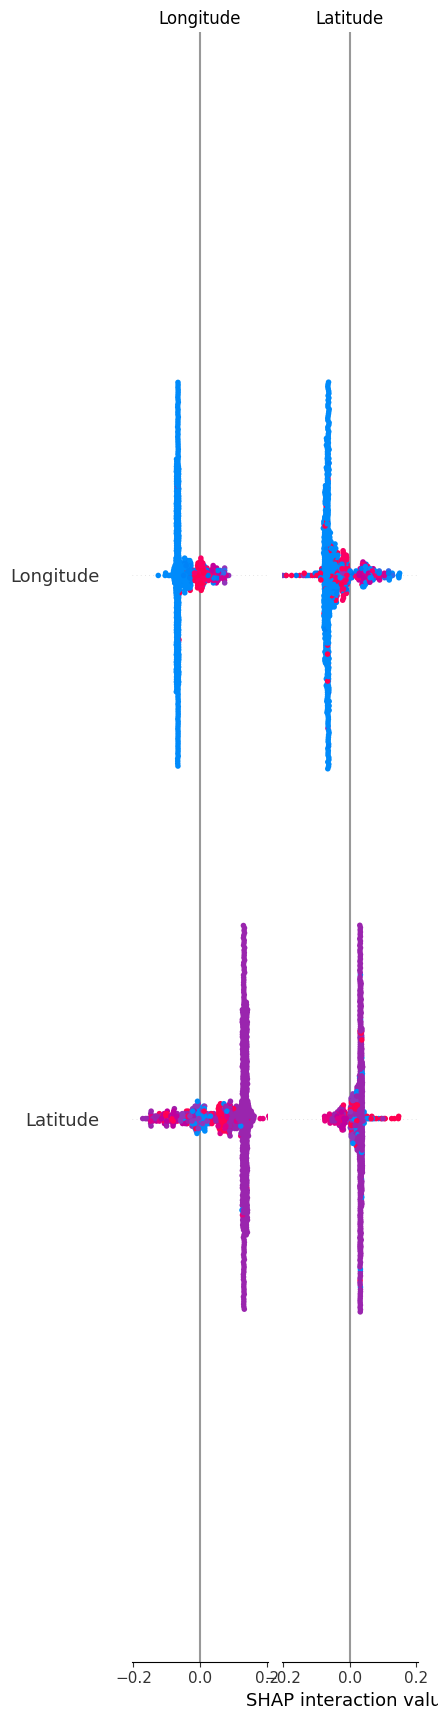

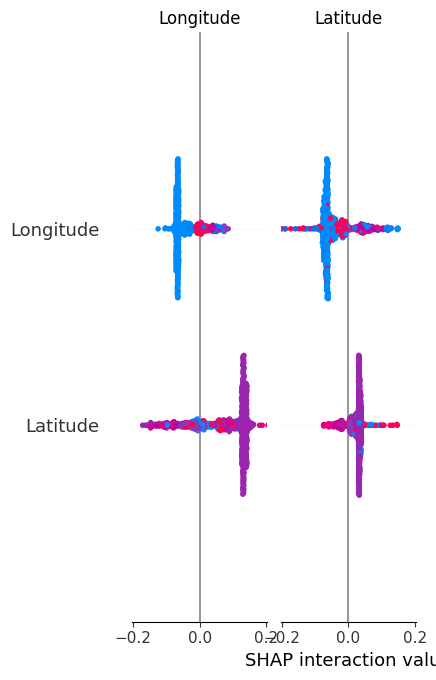

In [8]:
# ===============================
# Waterborne Outbreak Risk Prediction
# Hackathon Notebook
# ===============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import shap

# -------------------------------
# 1) Load Dataset
# -------------------------------
csv_path = "assamdata.csv"  # update path if needed
df = pd.read_csv(csv_path)
print("Loaded shape:", df.shape)

# -------------------------------
# 2) Define Outbreak Target
# -------------------------------
# Multi-condition health proxy
# df["target_outbreak"] = np.where(
#     (df["fcol_mpn"] > 500) |
#     (df["tcol_mpn"] > 500) |
#     (df["bod3_27"] > 3) |
#     (df["ph_gen"] < 6.5) | (df["ph_gen"] > 8.5) |
#     (df["_do"] < 4),
#     1, 0
# )

# print("Target distribution:")
# print(df["target_outbreak"].value_counts())

##

# Realism-focused outbreak definition:
# Keep thresholds closer to normal, but add overlap regions + mild noise
df["target_outbreak"] = np.where(
    (df["fcol_mpn"] > 400) |                # relaxed threshold (more overlap)
    (df["tcol_mpn"] > 400) |
    (df["bod3_27"] > 2.5) |                 # closer to normal values
    ((df["ph_gen"] < 6.7) | (df["ph_gen"] > 8.3)) |
    (df["_do"] < 4.2),
    1, 0
)

# Add randomness to borderline cases to mimic measurement error
import numpy as np
mask = (
    ((df["fcol_mpn"].between(350, 450)) |
     (df["tcol_mpn"].between(350, 450)) |
     (df["bod3_27"].between(2.3, 2.7)) |
     (df["ph_gen"].between(6.6, 6.8)) |
     (df["ph_gen"].between(8.2, 8.4)) |
     (df["_do"].between(4.0, 4.3)))
)
df.loc[mask, "target_outbreak"] = np.random.choice([0, 1], size=mask.sum(), p=[0.7, 0.3])

print("Target distribution (realism-focused):")
print(df["target_outbreak"].value_counts())




# -------------------------------
# 3) Feature Selection
# -------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = ["Year", "Month"]  # meta cols if present
features = [c for c in numeric_cols if c not in ["target_outbreak"] + drop_cols]

X = df[features].fillna(0)  # quick fix for NaNs
y = df["target_outbreak"]

# -------------------------------
# 4) Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------
# 5) Handle Imbalance (SMOTE)
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_res))

# -------------------------------
# 6) Train XGBoost (Main Model)
# -------------------------------
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
model.fit(X_train_res, y_train_res)

# -------------------------------
# 7) Evaluate XGBoost
# -------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("🔥 ROC-AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Safe","Outbreak"], yticklabels=["Safe","Outbreak"])
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# -------------------------------
# 8) Alert System
# -------------------------------
threshold = 0.3  # catch more outbreaks
df["outbreak_risk"] = model.predict_proba(X)[:, 1]
df["alert"] = (df["outbreak_risk"] > threshold).astype(int)

print("\n🚨 Alerts Raised:", df["alert"].sum(), "out of", len(df))

# -------------------------------
# 9) Interpretability (RandomForest + SHAP)
# -------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train_res, y_train_res)

# --- Feature Importance ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xticks(range(20), [X.columns[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# --- SHAP Analysis ---
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Take outbreak class if binary
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

print("SHAP shape:", np.array(shap_values_to_plot).shape, "X_test shape:", X_test.shape)

# Bar summary
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", max_display=20)

# Detailed beeswarm summary
shap.summary_plot(shap_values_to_plot, X_test)


In [4]:
print(df.columns.tolist())


['State', 'District', 'Basin', 'Sub_Basin', 'Station_Name', 'Station_Type', 'Date', 'Month', 'Year', 'Agency_name', 'Latitude', 'Longitude', '_24d', '_as', '_do', 'aldrin', 'alk_phen', 'alk_tot', 'b', 'barium', 'bhc', 'bod', 'bod3_27', 'ca', 'carbon_14', 'cd', 'chlf_a', 'cl', 'cn', 'co3', 'cocci', 'cod', 'cr', 'cu', 'data_gov_update_date', 'ddt', 'dieldrin', 'do_sat_', 'ec_fld', 'ec_gen', 'endos', 'f', 'fcol_mpn', 'fe', 'har_ca', 'har_mg', 'har_total', 'hco3', 'hg', 'k', 'mg', 'na', 'na_', 'nh3_n', 'ni', 'no2_n', 'no2_no3', 'no3_n', 'o_po4_p', 'org_n', 'p_tot', 'pah', 'pb', 'ph_fld', 'ph_gen', 'rsc', 'sar', 'secchi', 'sio2', 'sio3', 'so4', 'ss', 'tcol_mpn', 'tds', 'temp', 'toc', 'ts', 'turb', 'zn', '_401', 'ag', 'al', 'colour_cod', 'd_o', 'd_o_', 'mn', 'odour_code', 'oxygen_18', 'pcb', 'ph', 'phenols', 'radon', 'se', 'strontium', 'tritium', 'uranium', 'no2__n', 'caco3', 'mgcaco3', 'target_outbreak', 'outbreak_risk', 'alert']
